In [2]:
!pip install featurewiz
!pip install Pillow==9.0.0
!pip install xlrd
!pip install executing>0.10.0
!pip install imblearn
!pip install tensorflow

  Using cached scikit_learn-1.2.2-cp311-cp311-macosx_10_9_x86_64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp311-cp311-macosx_10_9_x86_64.whl (9.0 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.0
    Uninstalling scikit-learn-1.5.0:
      Successfully uninstalled scikit-learn-1.5.0

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade 

In [1]:
import numpy as np
import pandas as pd
import openpyxl as xl
import FILibExcel
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb 
import shap
from featurewiz import FeatureWiz

shap.initjs()

2024-07-09 18:51:45.988803: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Imported lazytransform v1.16. 

Imported featurewiz 0.5.7. Use the following syntax:
    >>> wiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True,
        		category_encoders="auto", auto_encoders='VAE', ae_options={},
        		add_missing=False, imbalanced=False, verbose=0)
    >>> X_train_selected, y_train = wiz.fit_transform(X_train, y_train)
    >>> X_test_selected = wiz.transform(X_test)
    >>> selected_features = wiz.features
    


In [2]:
excel_path = r"../../static/mock/antibio_data/20.02.2024 AntiBio_дополнено.xlsx"
artifacts_path = r"../../static/mock/antibio_artifacts/20-02/"

## Data Processing

In [3]:
tables_dict = FILibExcel.get_all_tables(file_name=excel_path)
df_compounds = tables_dict["CompoundsData"]['dataframe']
df_bacterias = tables_dict["BacteriasData"]['dataframe']
df_experiments = tables_dict["ExperimentsData"]['dataframe']


worksheet name: Table
tables in worksheet: 0

worksheet name: CompoundsData
tables in worksheet: 1
table name: CompoundsData

worksheet name: BacteriasData
tables in worksheet: 1
table name: BacteriasData

worksheet name: pH and concentration
tables in worksheet: 0

worksheet name: ExperimentsData
tables in worksheet: 1
table name: ExperimentsData

worksheet name: Legend-Main
tables in worksheet: 0

worksheet name: Bac
tables in worksheet: 0


In [4]:
# One hot encoding
types_num = 9
crystal_structure_names = []


for i in range(1, types_num + 1):
    new_name = f'Crystal structure type {i}'
    df_compounds[new_name] = 0
    crystal_structure_names.append(new_name)

for index, _ in df_compounds.iterrows():
    item = df_compounds.loc[index]
    if pd.isna(item['Crystal structure type']):
        if not pd.isna(item['Crystal structure type (literat.)']):
            i = int(item['Crystal structure type (literat.)'])
            df_compounds.loc[index, f'Crystal structure type {int(i)}'] = 1
        continue
        

    for i in str(item['Crystal structure type']).split(';'):
        df_compounds.loc[index, f'Crystal structure type {int(i)}'] = 1
df_compounds[crystal_structure_names]

Crystal structure type 1  Crystal structure type 2  \
0                          1                         0   
1                          1                         0   
2                          0                         1   
3                          0                         1   
4                          0                         1   
5                          0                         0   
6                          0                         1   
7                          0                         0   
8                          0                         1   
9                          0                         1   
10                         0                         1   
11                         0                         1   
12                         0                         1   
13                         0                         0   
14                         0                         1   
15                         0                         0   
16                         0                         0   
17                         0                         0   
18                         0                         0   
19                         0                         1   
20                         0                         0   
21                         0                         0   
22                         0                         0   

    Crystal structure type 3  Crystal structure type 4  \
0                          0                         0   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         0   
5                          1                         0   
6                          0                         0   
7                          1                         0   
8                          0                         0   
9                          0                         0   
10                         1                         0   
11                         1                         0   
12                         1                         0   
13                         1                         0   
14                         0                         0   
15                         1                         0   
16                         0                         1   
17                         0                         0   
18                         0                         0   
19                         0                         0   
20                         1                         0   
21                         0                         0   
22                         0                         0   

    Crystal structure type 5  Crystal structure type 6  \
0                          0                         0   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         0   
5                          0                         0   
6                          0                         0   
7                          0                         0   
8                          0                         0   
9                          0                         0   
10                         0                         0   
11                         0                         0   
12                         0                         0   
13                         0                         0   
14                         0                         0   
15                         0                         0   
16                         0                         0   
17                         0                         0   
18                         0                         1   
19                         0                         0   


In [5]:
df = df_experiments.merge(df_compounds, left_on='REE', right_on='REE').merge(df_bacterias, left_on='Bacteria', right_on='Name')
df.head().columns

Index(['REE', 'Bacteria', 'Salt/Solution', 'Stunting diameter', 'Ionic radii',
       '1st Ionization energy', '2nd Ionization energy',
       '3rd Ionization energy', '4th Ionization energy',
       'Crystal structure type', 'Crystal structure type (literat.)',
       '(salt)  d1-1H2O', '(salt)  d1-2H2O', '(salt)  d1-3H2O',
       '(salt) d1-4H2O', '(salt)  d1-5H2O', '(salt) d1-1NO3', '(salt) d1-2NO3',
       '(salt) d1-3NO3', '(salt) d1-4NO3', '(salt) d1-5NO3', '(salt) d1-6NO3',
       '(salt) d1', '(salt) d2-1NO3', '(salt) d2-2NO3', '(salt) d2-3NO3',
       '(salt) d3-1H2O', '(salt) d3-2H2O', 'Coordination number (solid) Ln-O',
       'Coordination number (solid) Ln-N', 'x', 'n',
       'Electronegativity, Oganov', 'Electronegativity, Malliken',
       'Electronegativity, Poland', 'Electronegativity, Allred-Rochow',
       'R1 (Ln-O)', 'R1 (Ln-N)', 'R2 (Ln-O)',
       'Coordination number solution 1(Ln-O)',
       'Coordination number solution  1(Ln-N)',
       'Coordination number 

In [6]:
salts_columns = ['Ionic radii', '1st Ionization energy', '2nd Ionization energy', '3rd Ionization energy', 
                                        '4th Ionization energy', '(salt)  d1-1H2O', '(salt)  d1-2H2O', '(salt)  d1-3H2O', '(salt) d1-4H2O',
                                        '(salt)  d1-5H2O', '(salt) d1-1NO3', '(salt) d1-2NO3', '(salt) d1-3NO3', '(salt) d1-4NO3',
                                        '(salt) d1-5NO3', '(salt) d1-6NO3', '(salt) d1', '(salt) d2-1NO3', '(salt) d2-2NO3', '(salt) d2-3NO3',
                                        '(salt) d3-1H2O', '(salt) d3-2H2O', 'Coordination number (solid) Ln-O', 'Coordination number (solid) Ln-N',
                                        'x', 'n', 'Electronegativity, Oganov', 'Electronegativity, Malliken', 'Electronegativity, Poland', 
                                        'Electronegativity, Allred-Rochow'] + crystal_structure_names
solution_columns = ['R1 (Ln-O)', 'R1 (Ln-N)', 'R2 (Ln-O)', 'Coordination number solution 1(Ln-O)', 
                                            'Coordination number solution  1(Ln-N)', 'Coordination number solution 2(Ln-O)', 'pH (conc=133,98)',
                                            'lgβ Ln(NO3)3', 'lgβ LnOH2-'] 

In [7]:
df_mixed = df.drop(['REE', 'Bacteria', 'Name', 'Electronic structure RE3+', 'Price', 'Name', 'Crystal structure type', 'Crystal structure type (literat.)'], axis=1)
df_mushrooms = df[df['Bacteria'].isin(['Candida albicans', 'Candida parapsilosis', 'Candida glabrata'])].drop(
    ['REE', 'Bacteria', 'Name', 'Electronic structure RE3+', 'Price', 'Gram-stain', 'Outer membrane', 'Membrane pore diameter min', 'Membrane pore diameter max', 'Penicillin sensitivity', 'Well layers',
    'Name', 'Crystal structure type', 'Crystal structure type (literat.)'], axis=1)
df_bacteria = df[~df['Bacteria'].isin(['Candida albicans', 'Candida parapsilosis', 'Candida glabrata'])].drop(['REE', 'Bacteria', 'Name', 'Electronic structure RE3+', 'Price', 'Name', 'Crystal structure type', 'Crystal structure type (literat.)'], axis=1) 

In [39]:
X_salts = df_mixed[df_mixed['Salt/Solution'] == 1].drop(solution_columns + ['Salt/Solution', 'Stunting diameter'], axis=1)
y_salts = df_mixed[df_mixed['Salt/Solution'] == 1]['Stunting diameter']
X_solutions = df_mixed[df_mixed['Salt/Solution'] == 0].drop(salts_columns + ['Salt/Solution', 'Stunting diameter'], axis=1)
y_solutions = df_mixed[df_mixed['Salt/Solution'] == 0]['Stunting diameter']

X_salts_bacteria = df_bacteria[df_bacteria['Salt/Solution'] == 1].drop(solution_columns + ['Salt/Solution', 'Stunting diameter'], axis=1)
y_salts_bacteria = df_bacteria[df_bacteria['Salt/Solution'] == 1]['Stunting diameter']

X_salts_mushrooms = df_mushrooms[df_mushrooms['Salt/Solution'] == 1].drop(solution_columns + ['Salt/Solution', 'Stunting diameter'], axis=1)
y_salts_mushrooms = df_mushrooms[df_mushrooms['Salt/Solution'] == 1]['Stunting diameter']

## Feature Engineering 

### Mixed

featurewiz is given 0.8 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['onehot', 'label']
    final list of scalers given: [std]
Loaded input data. Shape = (195, 52)
    selecting 52 numeric features for further processing...
#### Starting featurewiz transform for train data ####
    Regression models don't need targets to be transformed to numeric...
    Single_Label Regression problem 
Shape of dataset: (195, 52). Now we classify variables into different types...
    Returning dictionary for variable types with following keys:
                        continuous_vars = 43, int_vars = 9, 
                        discrete_string_vars = 0, nlp_vars = 0,
                        date_vars = 0, time_deltas = 0,
                        categorical_vars = 0, date_zones = 0
    no date time variables detected in this dataset
    Beware! onehot encoding can create hundreds if not 1000s of variables...
label enc

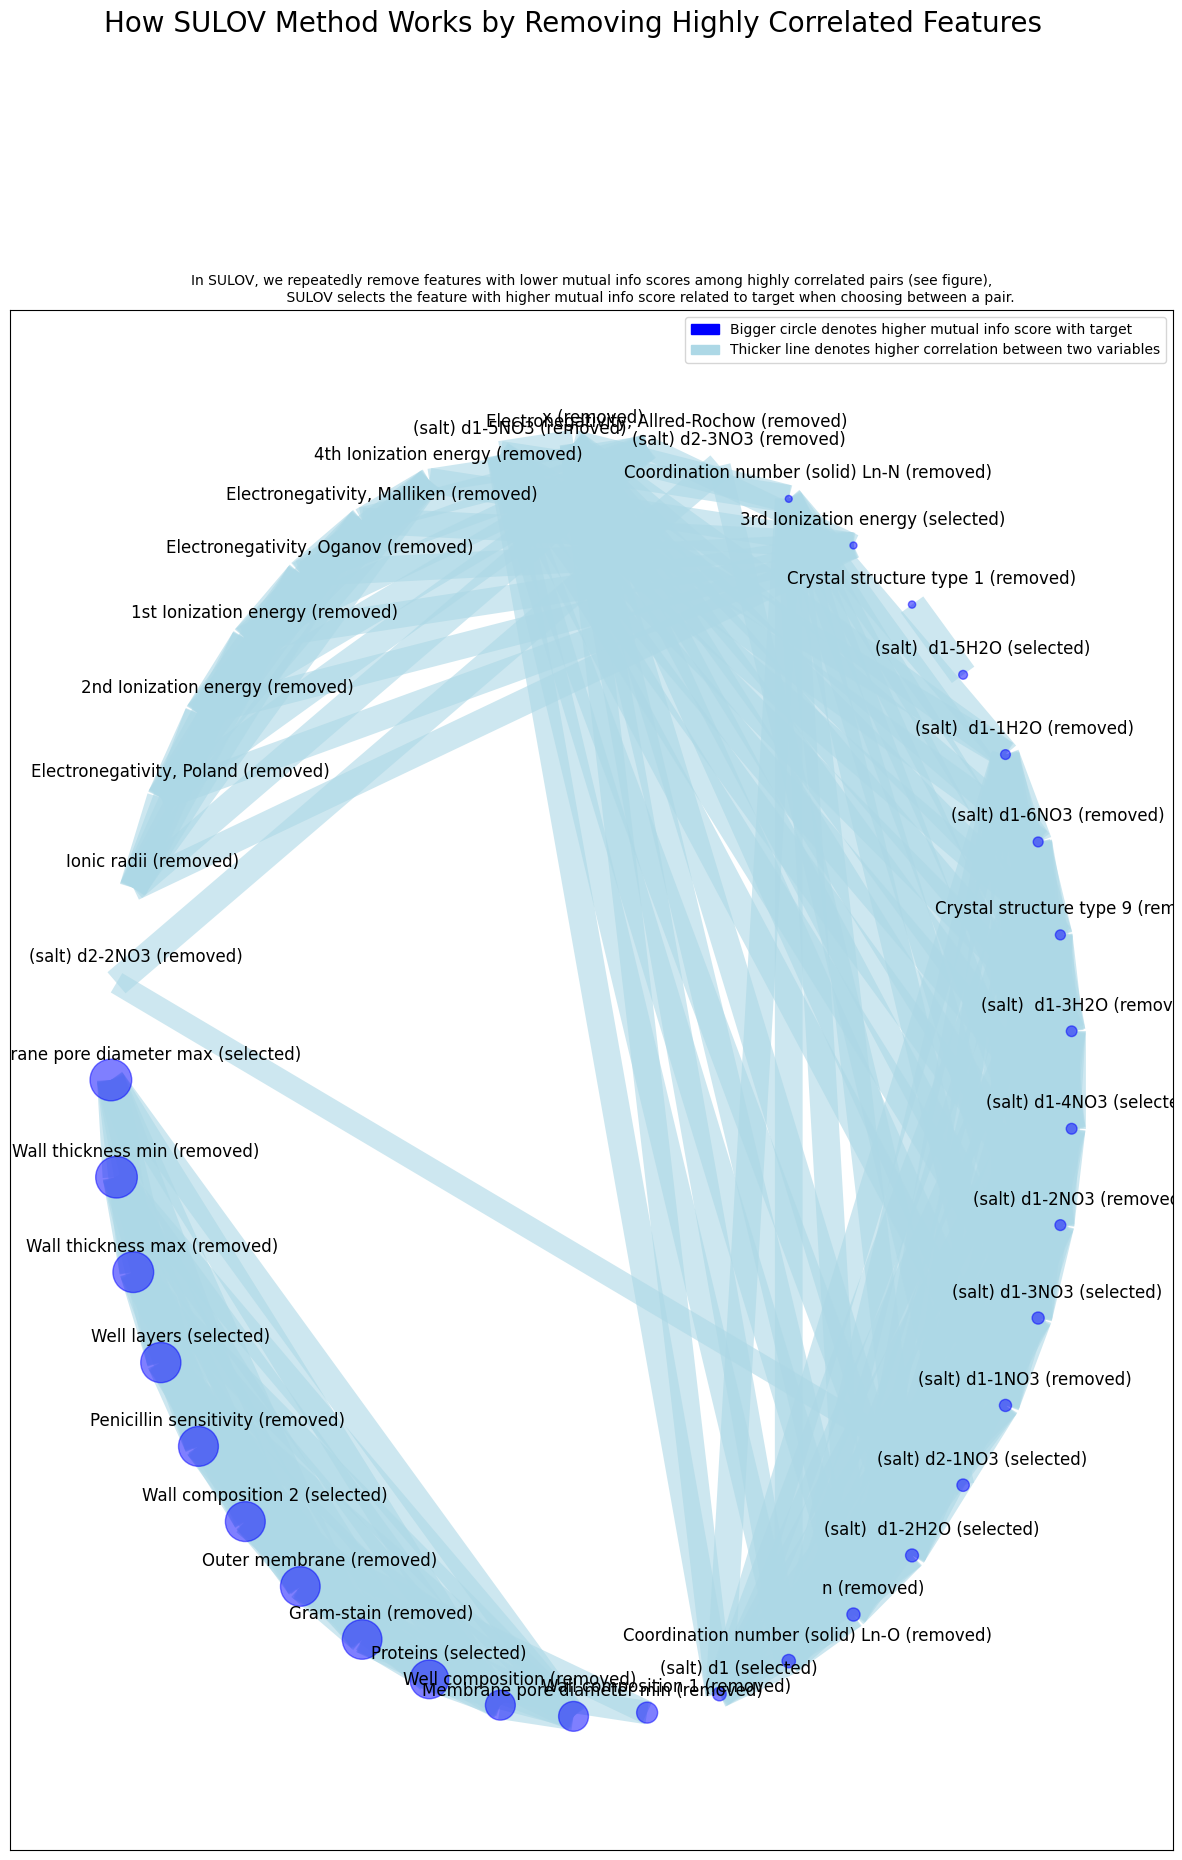

Performing recursive XGBoost feature selection from 21 features...
    Taking top 5 features per iteration...
    Number of booster rounds = 100
        Selected: ['Membrane pore diameter max', '3rd Ionization energy', '(salt) d1-4H2O', 'Crystal structure type 4', '(salt) d1']
            Time taken for regular XGBoost feature selection = 0 seconds
        Selected: ['Membrane pore diameter max', '3rd Ionization energy', '(salt) d1-4H2O', '(salt) d1', '(salt) d3-1H2O']
            Time taken for regular XGBoost feature selection = 0 seconds
        Selected: ['Membrane pore diameter max', '3rd Ionization energy', '(salt) d1', '(salt)  d1-2H2O', '(salt) d3-2H2O']
            Time taken for regular XGBoost feature selection = 0 seconds
        Selected: ['Wall composition 2', '3rd Ionization energy', '(salt) d1', '(salt)  d1-2H2O', '(salt) d2-1NO3']
            Time taken for regular XGBoost feature selection = 0 seconds
        Selected: ['3rd Ionization energy', '(salt) d2-1NO3', '(sal

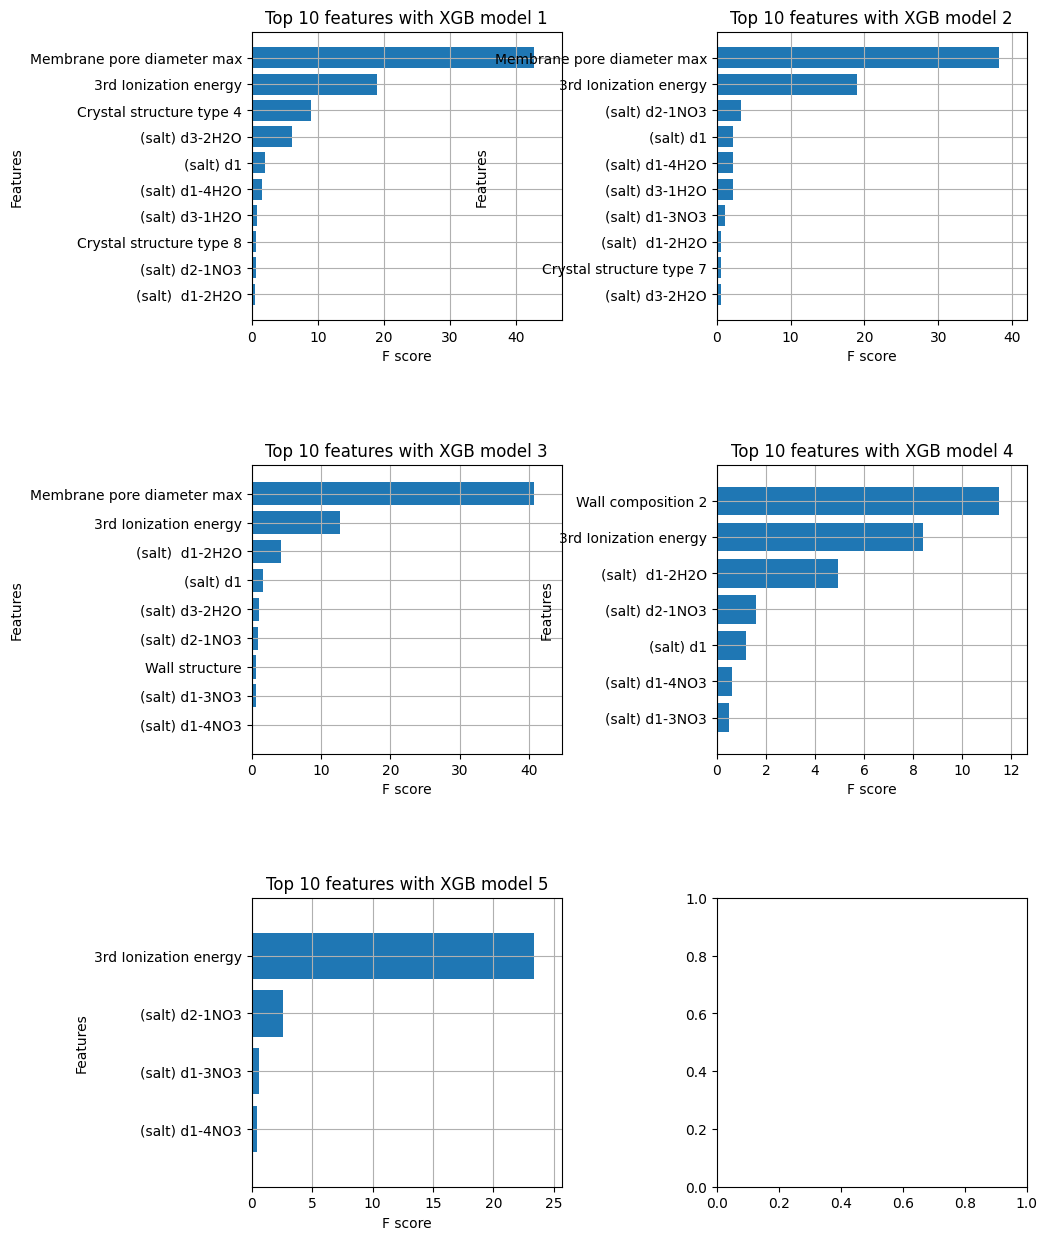

    time taken to run entire featurewiz = 2 second(s)
Recursive XGBoost selected 12 features...


['Membrane pore diameter max',
 '3rd Ionization energy',
 '(salt) d1-4H2O',
 'Crystal structure type 4',
 '(salt) d1',
 '(salt) d3-1H2O',
 '(salt)  d1-2H2O',
 '(salt) d3-2H2O',
 'Wall composition 2',
 '(salt) d2-1NO3',
 '(salt) d1-3NO3',
 '(salt) d1-4NO3']

In [9]:
fwiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True, scalers="std",
        		category_encoders="auto", add_missing=False, verbose=2, imbalanced=False, 
                ae_options={}, corr_limit=0.8)
X_salts_selected, y_salts = fwiz.fit_transform(X_salts, y_salts)
fwiz.features  

featurewiz is given 0.8 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['onehot', 'label']
    final list of scalers given: [std]
Loaded input data. Shape = (69, 22)
    selecting 22 numeric features for further processing...
#### Starting featurewiz transform for train data ####
    Single_Label Multi_Classification problem 
Shape of dataset: (69, 22). Now we classify variables into different types...
    Returning dictionary for variable types with following keys:
                        continuous_vars = 22, int_vars = 0, 
                        discrete_string_vars = 0, nlp_vars = 0,
                        date_vars = 0, time_deltas = 0,
                        categorical_vars = 0, date_zones = 0
    no date time variables detected in this dataset
    Beware! onehot encoding can create hundreds if not 1000s of variables...
label encoder selected for transforming all categorical variables
Using On

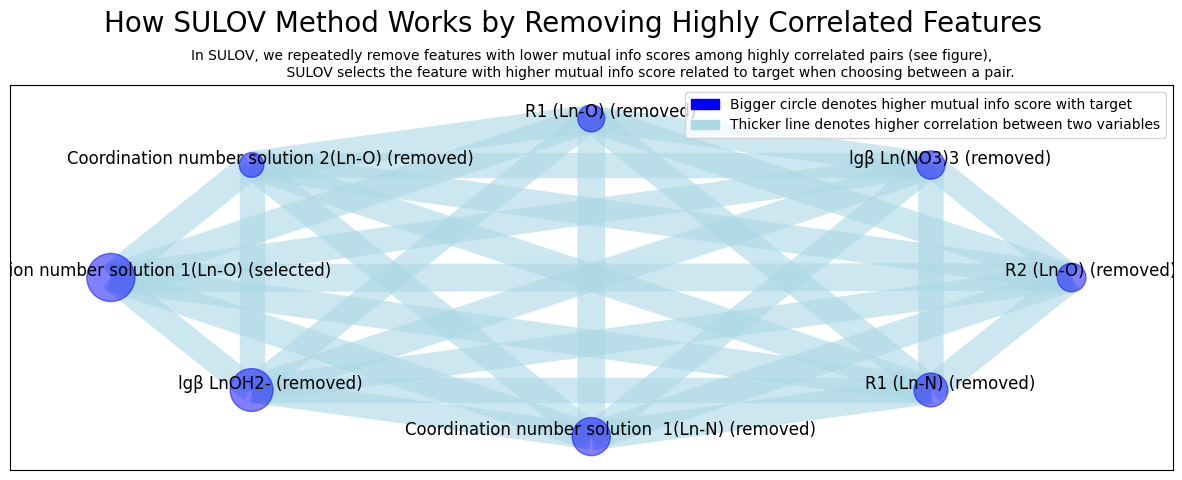

Performing recursive XGBoost feature selection from 13 features...
    Taking top 3 features per iteration...
    Number of booster rounds = 100
        Selected: ['pH (conc=133,98)', 'Coordination number solution 1(Ln-O)', 'Gram-stain']
            Time taken for regular XGBoost feature selection = 1 seconds
        Selected: ['Coordination number solution 1(Ln-O)', 'Wall thickness max']
            Time taken for regular XGBoost feature selection = 1 seconds
        Selected: ['Coordination number solution 1(Ln-O)', 'Wall composition 2']
            Time taken for regular XGBoost feature selection = 1 seconds
        Selected: ['Coordination number solution 1(Ln-O)', 'Proteins']
            Time taken for regular XGBoost feature selection = 1 seconds


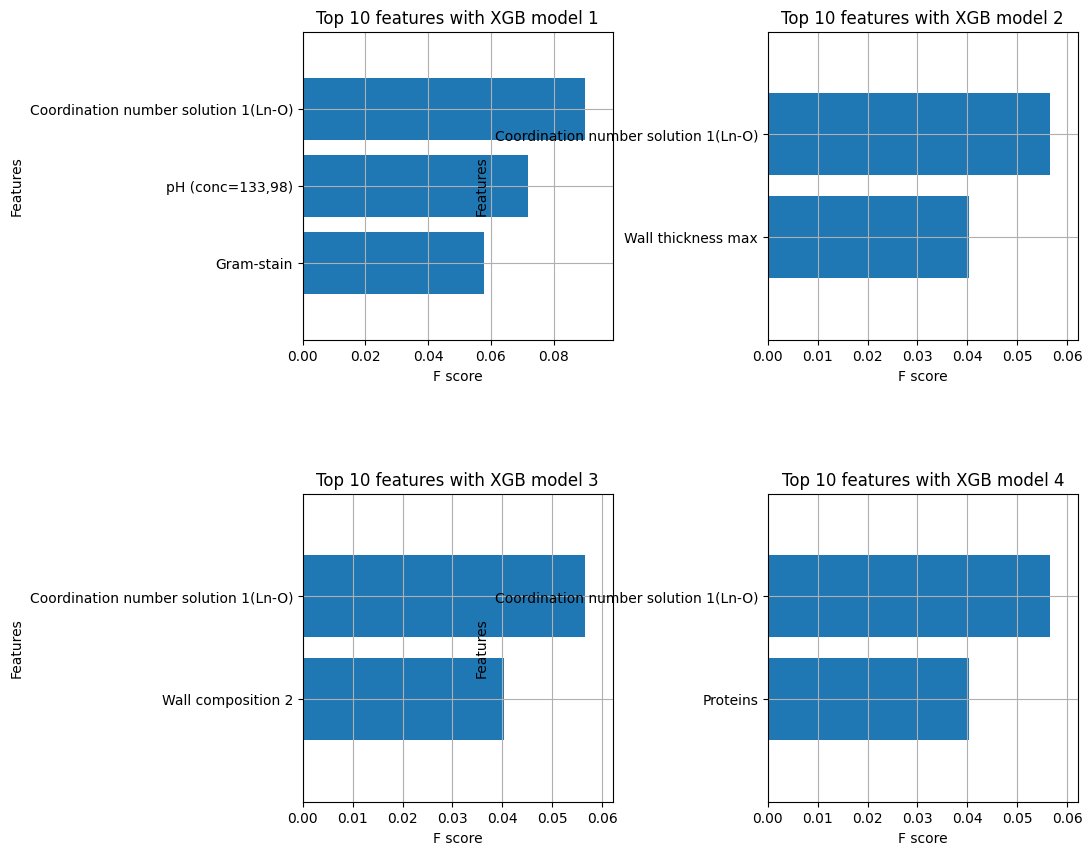

    time taken to run entire featurewiz = 4 second(s)
Recursive XGBoost selected 6 features...


['pH (conc=133,98)',
 'Coordination number solution 1(Ln-O)',
 'Gram-stain',
 'Wall thickness max',
 'Wall composition 2',
 'Proteins']

In [10]:
fwiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True, scalers="std",
        		category_encoders="auto", add_missing=False, verbose=2, imbalanced=False, 
                ae_options={}, corr_limit=0.8)
X_solution_selected, y_solutions = fwiz.fit_transform(X_solutions, y_solutions)
fwiz.features  

### Bacteria

featurewiz is given 0.8 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['onehot', 'label']
    final list of scalers given: [std]
Loaded input data. Shape = (138, 52)
    selecting 52 numeric features for further processing...
#### Starting featurewiz transform for train data ####
    Single_Label Multi_Classification problem 
Shape of dataset: (138, 52). Now we classify variables into different types...
    Returning dictionary for variable types with following keys:
                        continuous_vars = 43, int_vars = 9, 
                        discrete_string_vars = 0, nlp_vars = 0,
                        date_vars = 0, time_deltas = 0,
                        categorical_vars = 0, date_zones = 0
    no date time variables detected in this dataset
    Beware! onehot encoding can create hundreds if not 1000s of variables...
label encoder selected for transforming all categorical variables
Using 

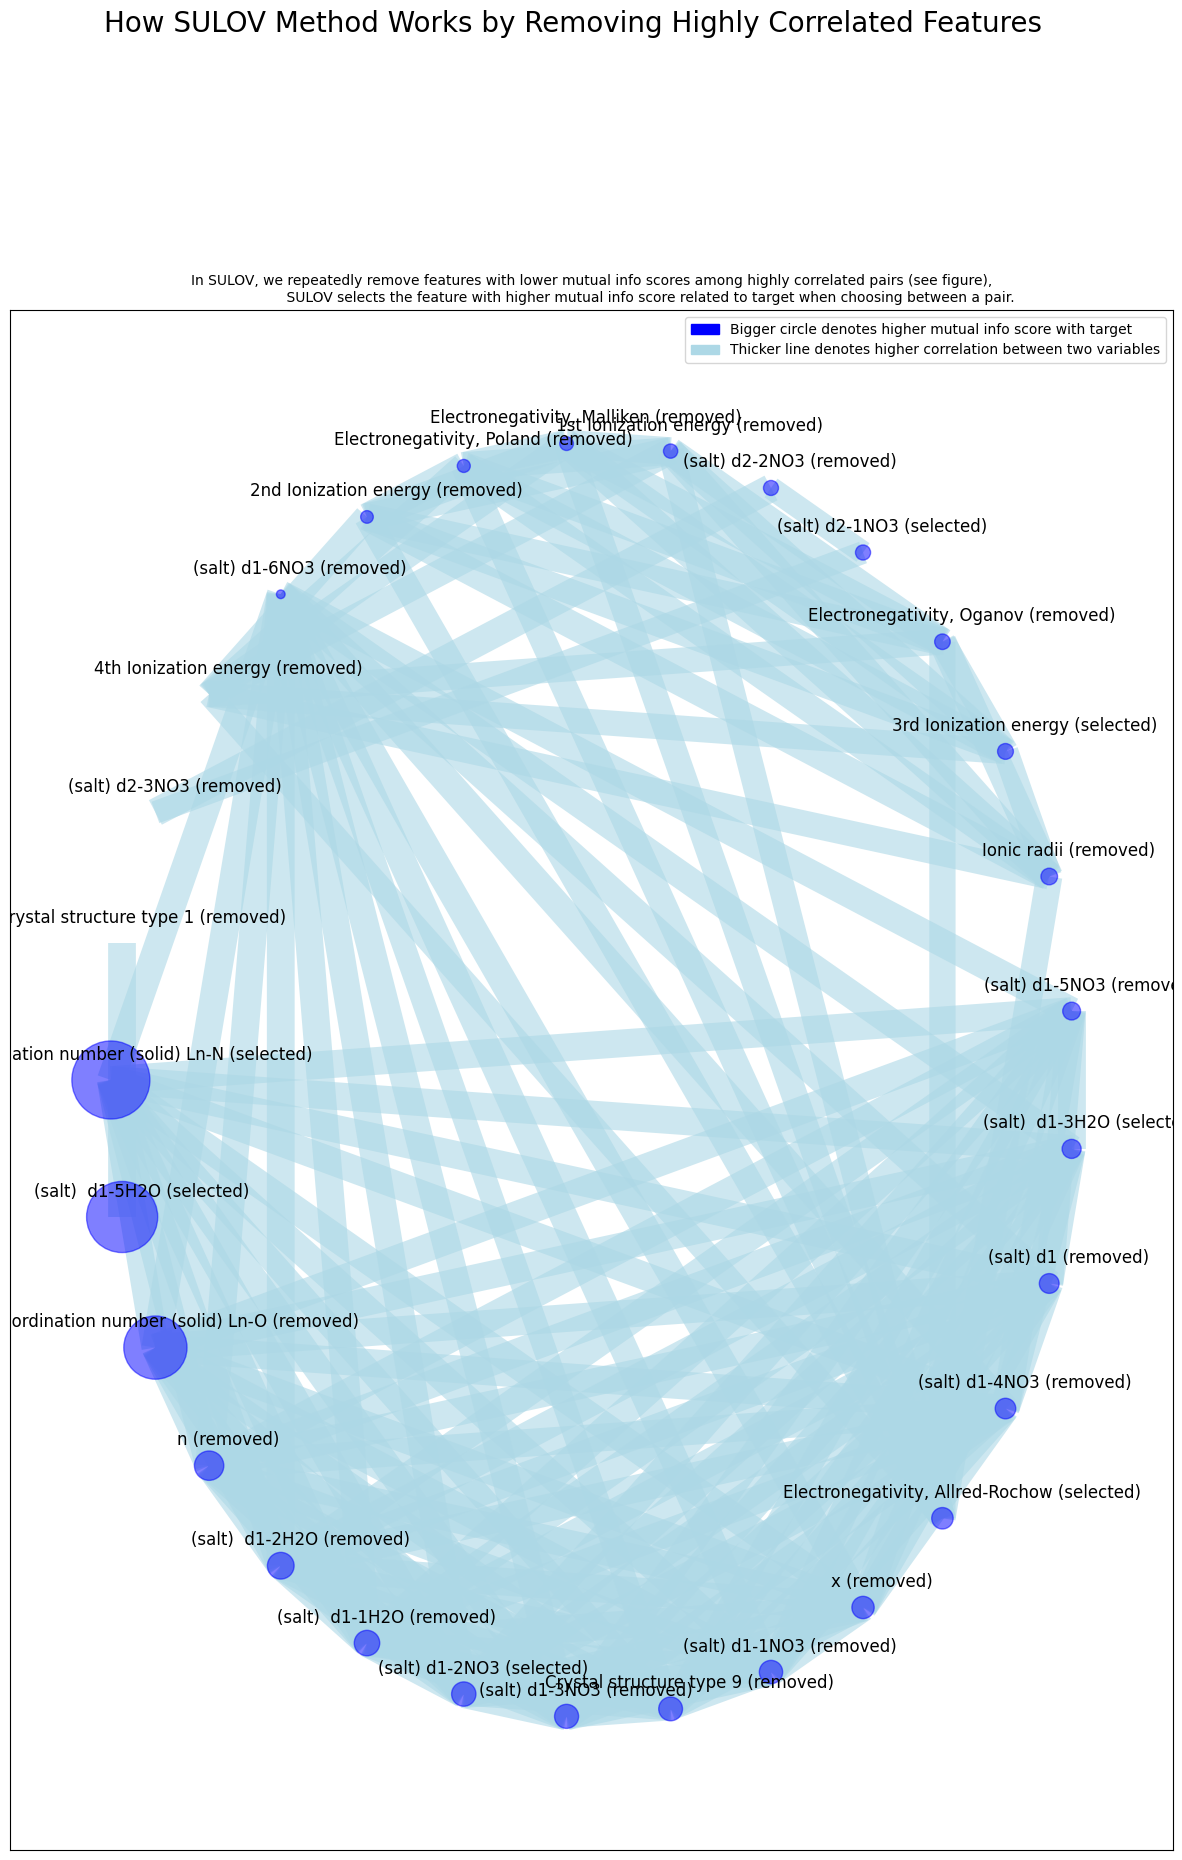

Performing recursive XGBoost feature selection from 27 features...
    Taking top 6 features per iteration...
    Number of booster rounds = 100
        Selected: ['Gram-stain', '(salt) d1-2NO3', '(salt) d3-1H2O', '3rd Ionization energy', '(salt) d1-4H2O', '(salt) d2-1NO3']
            Time taken for regular XGBoost feature selection = 2 seconds
        Selected: ['Gram-stain', '(salt) d1-2NO3', '(salt) d3-1H2O', '3rd Ionization energy', '(salt) d1-4H2O', '(salt) d2-1NO3']
            Time taken for regular XGBoost feature selection = 2 seconds
        Selected: ['(salt) d1-2NO3', 'Wall thickness min', '3rd Ionization energy', '(salt)  d1-3H2O', '(salt) d2-1NO3', 'Electronegativity, Allred-Rochow']
            Time taken for regular XGBoost feature selection = 2 seconds
        Selected: ['(salt) d1-2NO3', 'Outer membrane', '3rd Ionization energy', '(salt)  d1-3H2O', '(salt) d2-1NO3', 'Electronegativity, Allred-Rochow']
            Time taken for regular XGBoost feature selection = 2 s

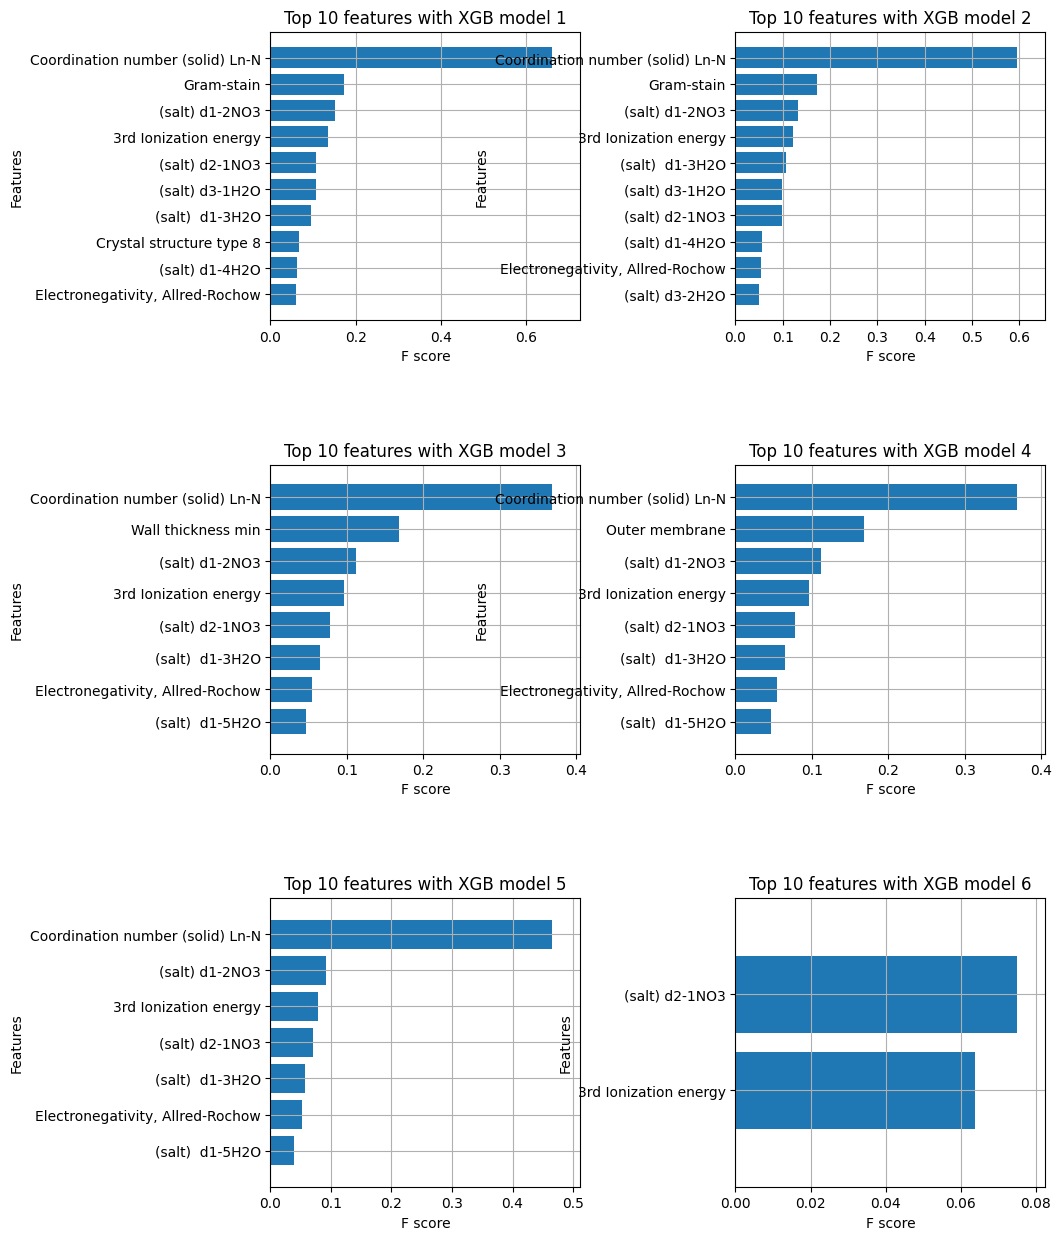

    time taken to run entire featurewiz = 13 second(s)
Recursive XGBoost selected 11 features...


['Gram-stain',
 '(salt) d1-2NO3',
 '(salt) d3-1H2O',
 '3rd Ionization energy',
 '(salt) d1-4H2O',
 '(salt) d2-1NO3',
 'Wall thickness min',
 '(salt)  d1-3H2O',
 'Electronegativity, Allred-Rochow',
 'Outer membrane',
 '(salt)  d1-5H2O']

In [11]:
fwiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True, scalers="std",
        		category_encoders="auto", add_missing=False, verbose=2, imbalanced=False, 
                ae_options={}, corr_limit=0.8)
X_salts_bacteria_selected, y_salts_bacteria = fwiz.fit_transform(X_salts_bacteria, y_salts_bacteria)
fwiz.features  

### Mushrooms

featurewiz is given 0.8 as correlation limit...
    Skipping feature engineering since no feature_engg input...
    final list of category encoders given: ['onehot', 'label']
    final list of scalers given: [std]
Loaded input data. Shape = (57, 46)
    selecting 46 numeric features for further processing...
#### Starting featurewiz transform for train data ####
    Single_Label Multi_Classification problem 
Shape of dataset: (57, 46). Now we classify variables into different types...
    Returning dictionary for variable types with following keys:
                        continuous_vars = 37, int_vars = 9, 
                        discrete_string_vars = 0, nlp_vars = 0,
                        date_vars = 0, time_deltas = 0,
                        categorical_vars = 0, date_zones = 0
    no date time variables detected in this dataset
    Beware! onehot encoding can create hundreds if not 1000s of variables...
label encoder selected for transforming all categorical variables
Using On

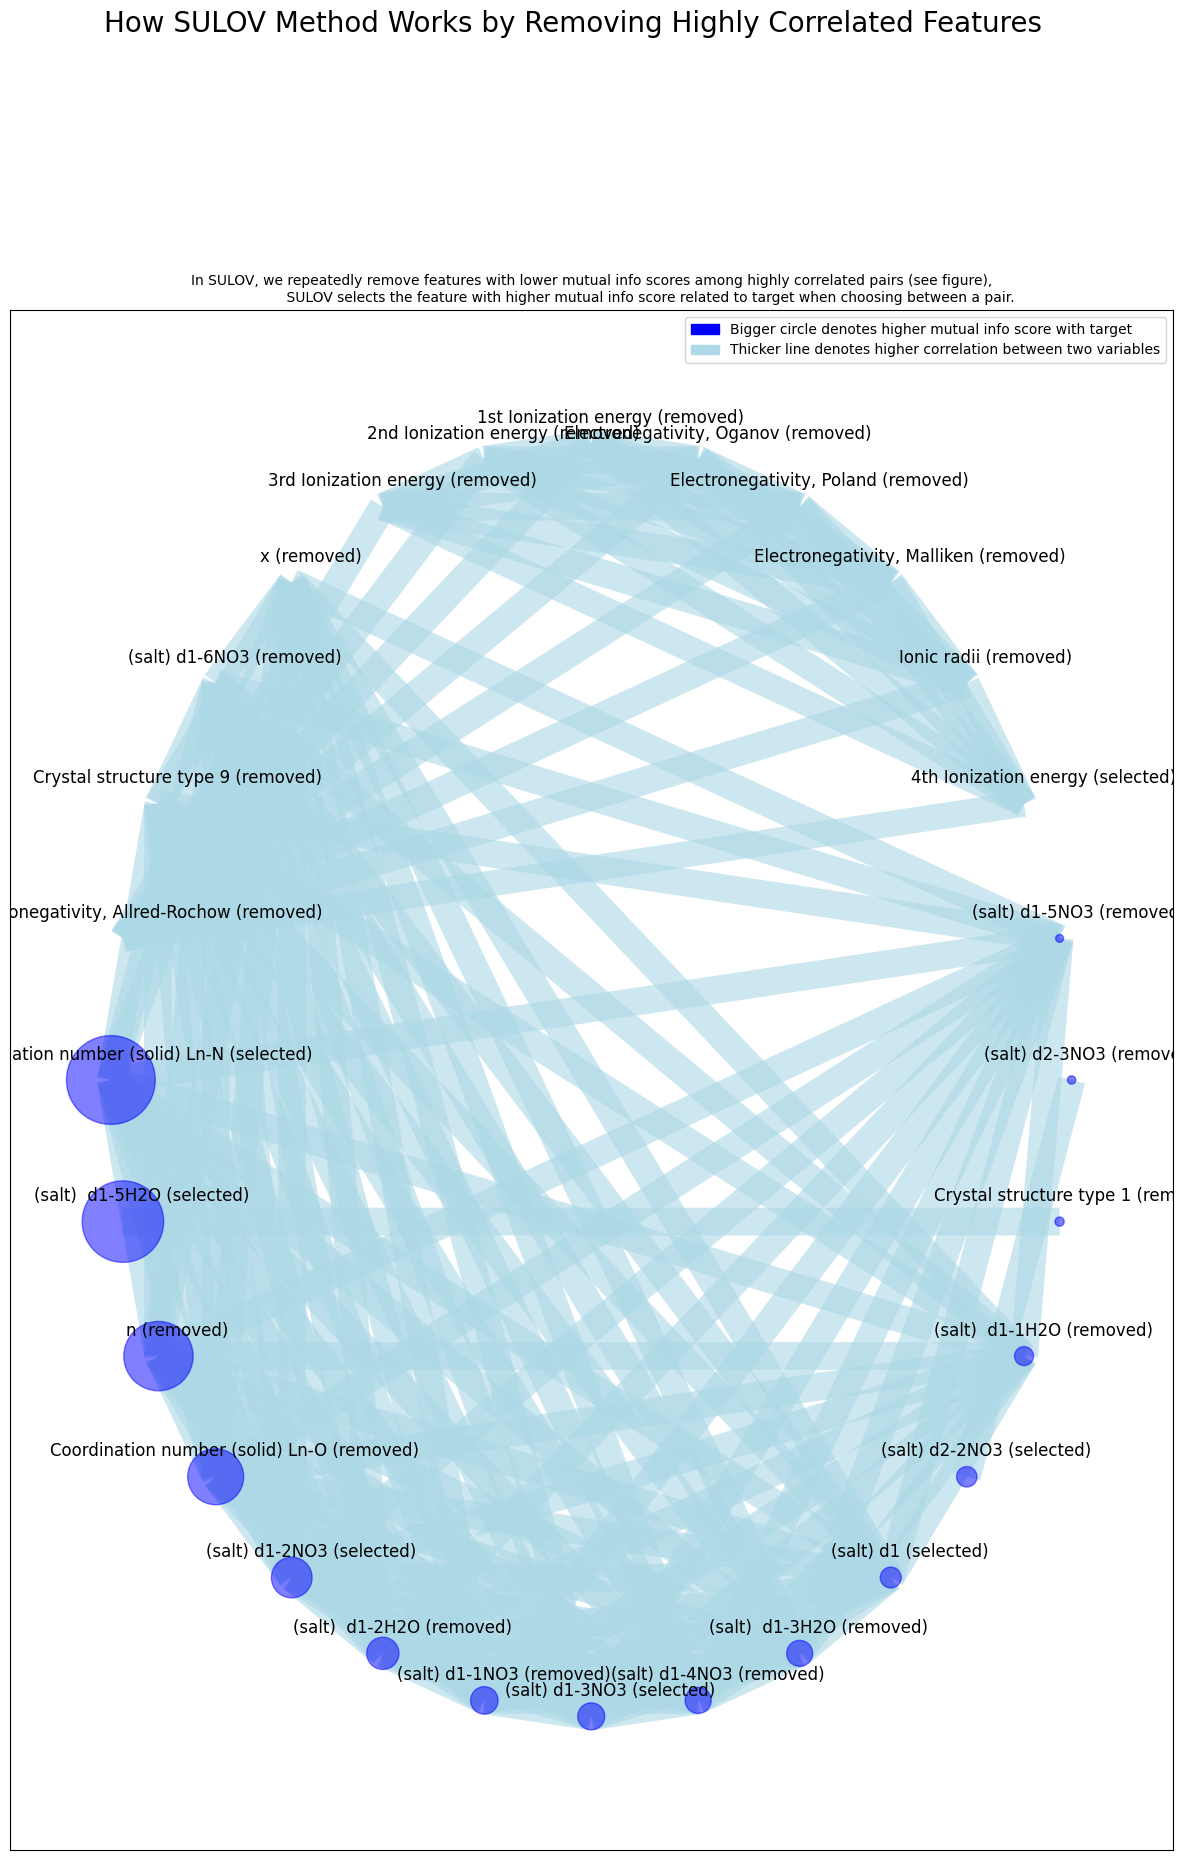

Performing recursive XGBoost feature selection from 17 features...
    Taking top 4 features per iteration...
    Number of booster rounds = 100
        Selected: ['(salt) d1-4H2O', '(salt) d2-1NO3', '(salt) d3-1H2O', '(salt) d1-2NO3']
            Time taken for regular XGBoost feature selection = 1 seconds
        Selected: ['(salt) d1-4H2O', '(salt) d2-1NO3', '(salt) d3-1H2O', '(salt) d1-2NO3']
            Time taken for regular XGBoost feature selection = 1 seconds
        Selected: ['(salt) d1-4H2O', '(salt) d2-1NO3', '(salt) d3-1H2O', '(salt) d1-2NO3']
            Time taken for regular XGBoost feature selection = 1 seconds
        Selected: ['(salt) d1-2NO3', '(salt) d2-2NO3', '4th Ionization energy', '(salt) d3-2H2O']
            Time taken for regular XGBoost feature selection = 1 seconds
        Selected: ['(salt) d1-2NO3', '(salt) d2-2NO3', '4th Ionization energy', '(salt) d1']
            Time taken for regular XGBoost feature selection = 1 seconds
        Selected: ['(salt)

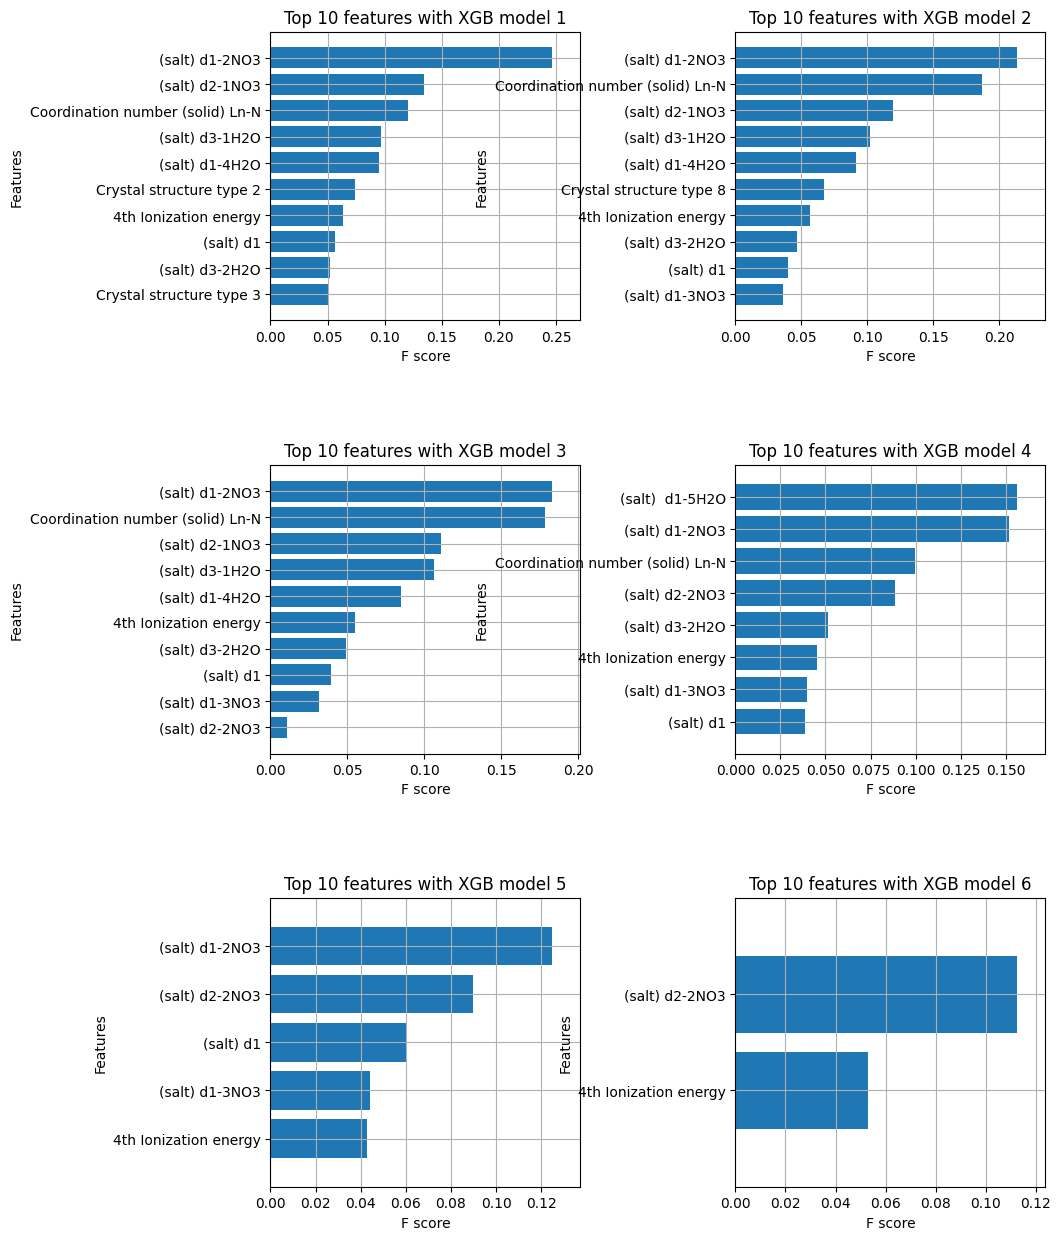

    time taken to run entire featurewiz = 9 second(s)
Recursive XGBoost selected 8 features...


['(salt) d1-4H2O',
 '(salt) d2-1NO3',
 '(salt) d3-1H2O',
 '(salt) d1-2NO3',
 '(salt) d2-2NO3',
 '4th Ionization energy',
 '(salt) d3-2H2O',
 '(salt) d1']

In [12]:
fwiz = FeatureWiz(feature_engg = '', nrows=None, transform_target=True, scalers="std",
        		category_encoders="auto", add_missing=False, verbose=2, imbalanced=False, 
                ae_options={}, corr_limit=0.8)
X_salts_mushrooms_selected, y_salts_mushrooms = fwiz.fit_transform(X_salts_mushrooms, y_salts_mushrooms)
fwiz.features  

## Utils

In [27]:
def learn_xgboost(X, y, is_show_params=True):
    parameters = {
        'min_child_weight': [1, 5, 7, 10, 11, 12, 15,],
        'gamma': [0.5, 1, 1.5, 2, 2.5, 3, 5],
        'subsample': [0.4, 0.5, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
    }

    model = xgb.XGBRegressor(learning_rate=0.02, n_estimators=600, nthread=1, seed=0)
    clf = GridSearchCV(
        model, 
        parameters, 
        cv=5, 
        scoring=['neg_mean_absolute_error', 'r2', 'neg_mean_squared_error', 'explained_variance', 'neg_mean_absolute_percentage_error'],
        refit='neg_mean_absolute_percentage_error',
        n_jobs=-1)
    clf.fit(X, y)
    best_model = clf.best_estimator_
    scores = {}
    print("MAE: ", -clf.best_score_)
    scores['MAE'] = -clf.best_score_
    if is_show_params:
        print(clf.best_params_)
    print("R2: ", clf.cv_results_['mean_test_r2'].max())
    scores['R2'] = clf.cv_results_['mean_test_r2'].max()
    print("MSE: ", -clf.cv_results_['mean_test_neg_mean_squared_error'].max())
    scores['MSE'] = -clf.cv_results_['mean_test_neg_mean_squared_error'].max()
    print("EVS: ", clf.cv_results_['mean_test_explained_variance'].max())
    scores['EVS'] = clf.cv_results_['mean_test_explained_variance'].max()
    print("MAPE: ", clf.cv_results_['mean_test_neg_mean_absolute_percentage_error'])
    return best_model, scores, clf

In [18]:
def explain(model, X, name="model", is_save=False, color_bar=False):
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values, max_display=20, plot_size=[10, 6], show=False, color_bar=color_bar)
    if is_save:
        plt.savefig(f'{artifacts_path}{name}_shap.png', bbox_inches='tight')
    plt.show()

## Model Training

In [15]:
xgb_salts, score_salts = learn_xgboost(X_salts_selected, y_salts)

ValueError: The list/tuple elements must be unique strings of predefined scorers.  Duplicate elements were found in the given list. ['neg_mean_absolute_error', 'r2', 'neg_mean_squared_error', 'explained_variance', 'neg_mean_absolute_error']

In [19]:
xgb_solutions, score_solutions = learn_xgboost(X_solution_selected, y_solutions)

MAE:  704677493095044.1
{'colsample_bytree': 0.4, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 15, 'subsample': 0.4}
R2:  -0.5172793442094618
MSE:  6.258050663147327
EVS:  0.08247545554777938
MAPE:  -704677493095044.1


In [20]:
xgb_salts_bacteria, score_salts_bacteria = learn_xgboost(X_salts_bacteria_selected, y_salts_bacteria)

MAE:  385524026108431.25
{'colsample_bytree': 0.4, 'gamma': 2, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.4}
R2:  -0.6703256741931538
MSE:  32.262311427047656
EVS:  0.0697286743827215
MAPE:  -385524026108431.25


In [28]:
xgb_salts_mushrooms, score_salts_mushrooms, clf = learn_xgboost(X_salts_mushrooms_selected, y_salts_mushrooms)

MAE:  467973428392160.0
{'colsample_bytree': 0.5, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.4}
R2:  0.29896274811376006
MSE:  15.414160531093279
EVS:  0.3780235312339495
MAPE:  [-5.11271892e+14 -5.19187868e+14 -5.05136101e+14 ... -1.13476285e+15
 -9.70094072e+14 -1.02786142e+15]


In [43]:
from sklearn.metrics import mean_absolute_percentage_error

1.94 / y_solutions.mean()

0.09168493150684931

## Explain

### Beeswarm

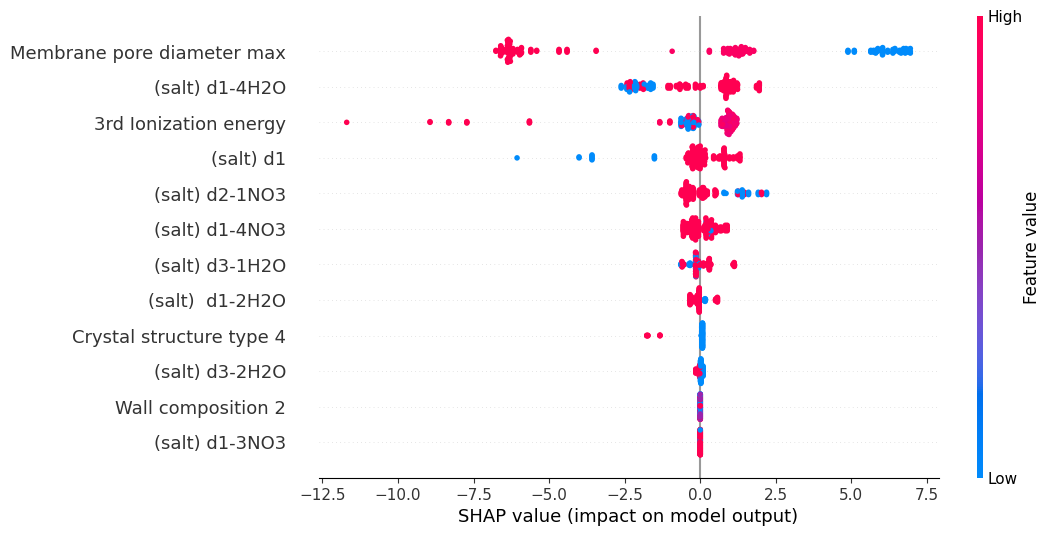

In [25]:
explain(xgb_salts, X_salts_selected, 'salts_all_data', True, True)

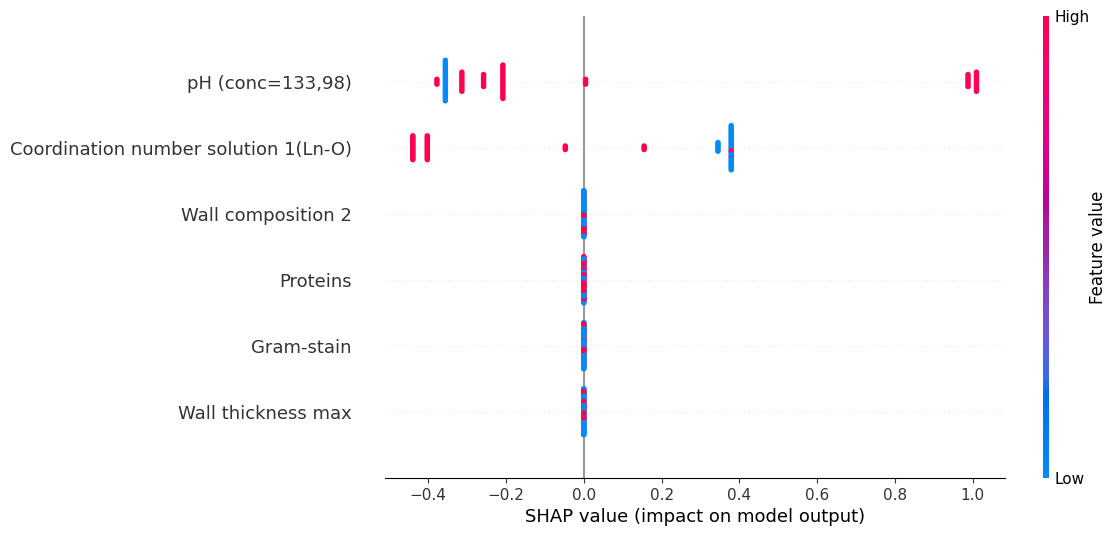

In [26]:
explain(xgb_solutions, X_solution_selected, 'solutions_all_data', True, True)

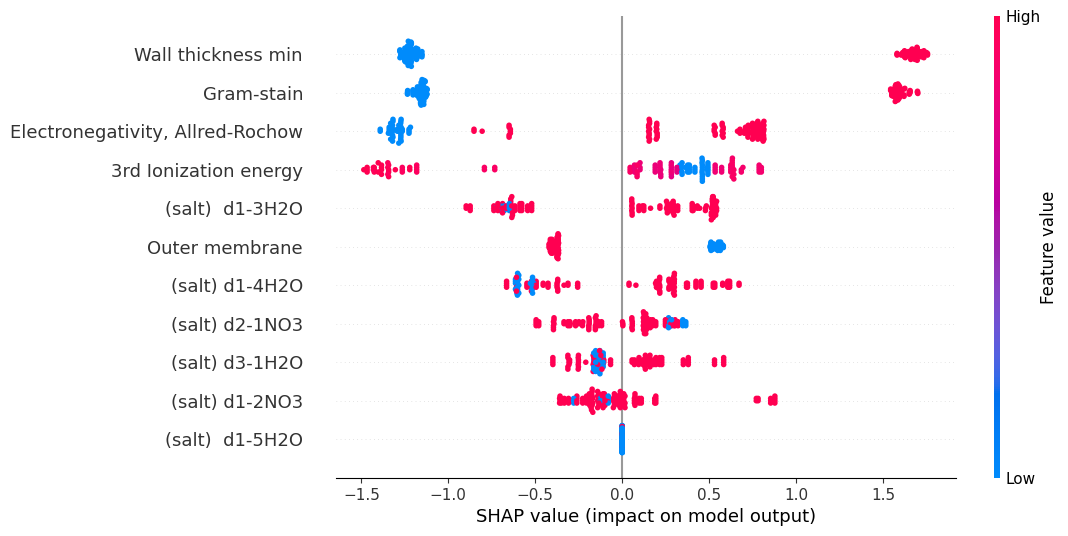

In [27]:
explain(xgb_salts_bacteria, X_salts_bacteria_selected, 'salts_bacteria_data', True, True)

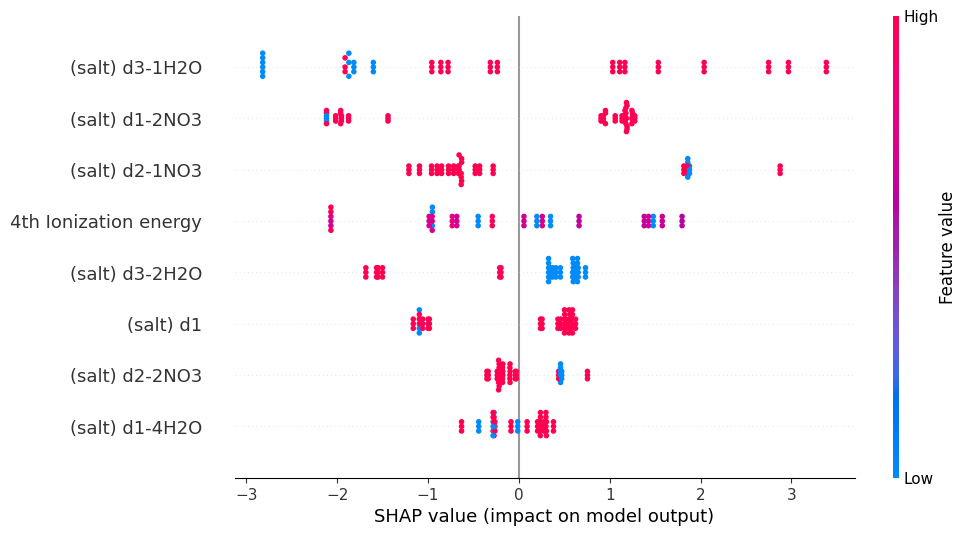

In [29]:
explain(xgb_salts_mushrooms, X_salts_mushrooms_selected, 'salts_mushrooms_data', True, True)

### Force

In [32]:
explainer = shap.Explainer(xgb_salts, X_salts_selected)
shap_values = explainer(X_salts_selected)
shap.plots.force(shap_values)

In [33]:
explainer = shap.Explainer(xgb_solutions, X_solution_selected)
shap_values = explainer(X_solution_selected)
shap.plots.force(shap_values)

In [34]:
explainer = shap.Explainer(xgb_salts_bacteria, X_salts_bacteria_selected)
shap_values = explainer(X_salts_bacteria_selected)
shap.plots.force(shap_values)

In [35]:
explainer = shap.Explainer(xgb_salts_mushrooms, X_salts_mushrooms_selected)
shap_values = explainer(X_salts_mushrooms_selected)
shap.plots.force(shap_values)